# Deep Graph Library

<a href="https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, setting up our environment.

In [2]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl
!pip3 install numpy

In [24]:
%matplotlib inline

In [19]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

Remember the Karate Club ![karate](img/karate_club.png)

In [9]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [10]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


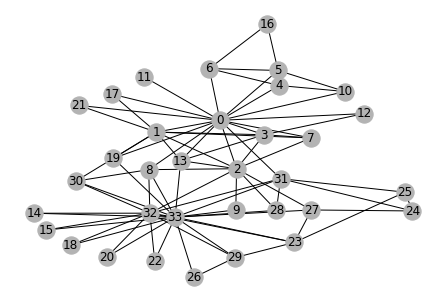

In [11]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [15]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 0.3398,  0.7139, -1.0455,  0.6872, -0.3698], grad_fn=<SelectBackward>)
tensor([[ 0.7061, -1.0786, -1.3295,  1.5782,  0.5494],
        [ 0.7990, -0.2199, -0.3587, -0.1564, -0.3498]],
       grad_fn=<IndexBackward>)


# Create GCN

In [18]:
 class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

Label the instructor and president

In [21]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [22]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7846
Epoch 1 | Loss: 0.7656
Epoch 2 | Loss: 0.7487
Epoch 3 | Loss: 0.7337
Epoch 4 | Loss: 0.7203
Epoch 5 | Loss: 0.7082
Epoch 6 | Loss: 0.6977
Epoch 7 | Loss: 0.6895
Epoch 8 | Loss: 0.6819
Epoch 9 | Loss: 0.6748
Epoch 10 | Loss: 0.6679
Epoch 11 | Loss: 0.6611
Epoch 12 | Loss: 0.6541
Epoch 13 | Loss: 0.6467
Epoch 14 | Loss: 0.6384
Epoch 15 | Loss: 0.6292
Epoch 16 | Loss: 0.6193
Epoch 17 | Loss: 0.6085
Epoch 18 | Loss: 0.5975
Epoch 19 | Loss: 0.5847
Epoch 20 | Loss: 0.5716
Epoch 21 | Loss: 0.5578
Epoch 22 | Loss: 0.5430
Epoch 23 | Loss: 0.5272
Epoch 24 | Loss: 0.5105
Epoch 25 | Loss: 0.4931
Epoch 26 | Loss: 0.4745
Epoch 27 | Loss: 0.4551
Epoch 28 | Loss: 0.4349
Epoch 29 | Loss: 0.4140
Epoch 30 | Loss: 0.3925
Epoch 31 | Loss: 0.3707
Epoch 32 | Loss: 0.3485
Epoch 33 | Loss: 0.3263
Epoch 34 | Loss: 0.3041
Epoch 35 | Loss: 0.2827
Epoch 36 | Loss: 0.2615
Epoch 37 | Loss: 0.2405
Epoch 38 | Loss: 0.2203
Epoch 39 | Loss: 0.2009
Epoch 40 | Loss: 0.1824
Epoch 41 | Loss: 0.1650
Ep

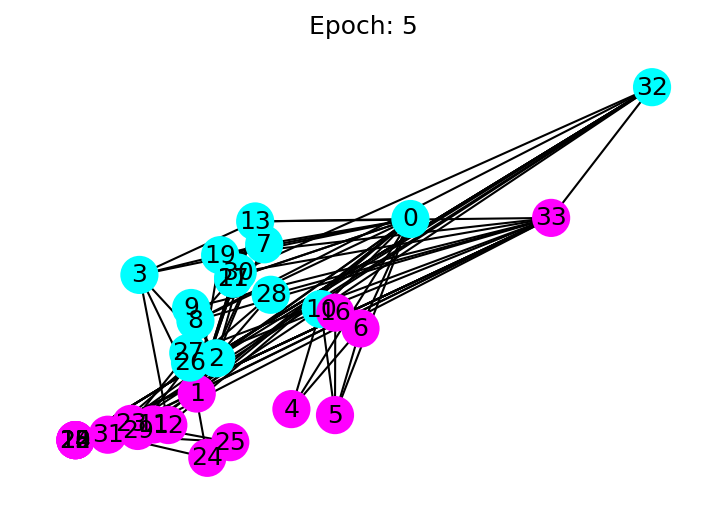

In [34]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(5) # Iterate to see different epochs
plt.show()
plt.close()

Next task: Try to implement graph classification (https://docs.dgl.ai/tutorials/basics/4_batch.html)

 ![Graph Types](img/graph_types.png)